# LSTM Next Word Predictor

This notebook demonstrates how to build a simple LSTM model to predict the next word in a sequence, trained on a toy text dataset.

LSTM Architecure

Refer to this [link](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) for more information on the architecture.

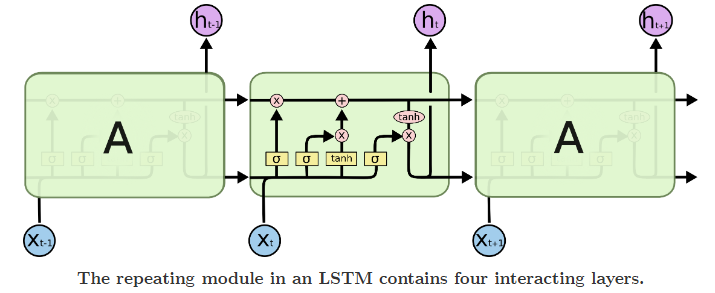

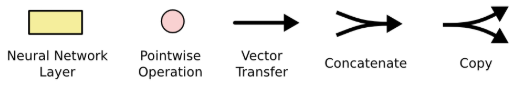

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

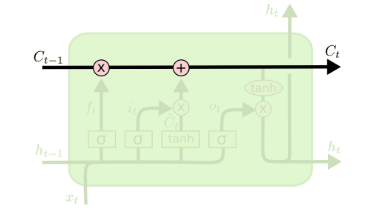

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

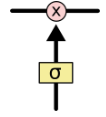

The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

An LSTM has three of these gates, to protect and control the cell state.

**1. Forget gate layer** : The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a **sigmoid layer** called the “forget gate layer.” It looks at $ h_{t−1} $ and $ x_t $ , and outputs a number between 0 and 1 for each number in the cell state $ C_{t−1} $.

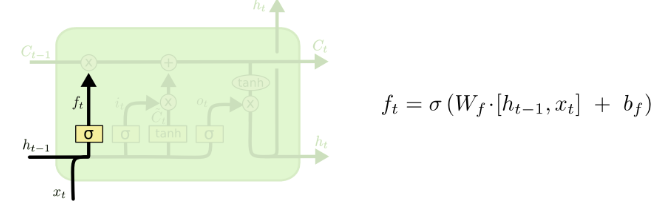

**2. Input gate layer** : The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a **sigmoid layer** called the “input gate layer” decides which values we’ll update. Next, a **tanh** layer creates a vector of new candidate values, $ \tilde C_t $, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

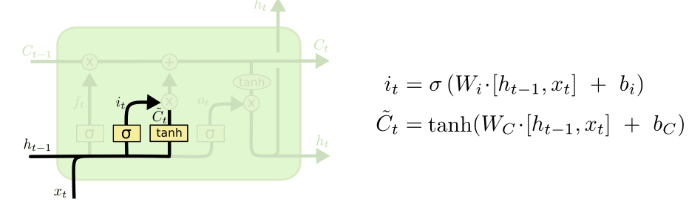

It’s now time to update the old cell state, $ C_{t−1} $, into the new cell state $ C_{t} $. The previous steps already decided what to do, we just need to actually do it.

We multiply the old state by $ f_{t} $, forgetting the things we decided to forget earlier. Then we add $ i_t ∗ \tilde C_t $. This is the new candidate values, scaled by how much we decided to update each state value.

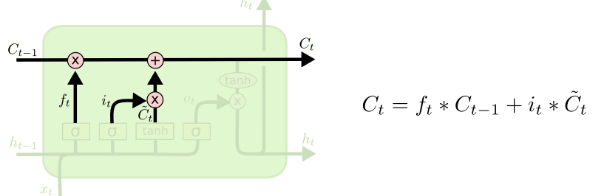

**3. Output Gate** : Finally, we need to decide what we’re going to output. This output will be based on our **cell state**, but will be a filtered version. First, we run a **sigmoid layer** which decides what parts of the cell state we’re going to output. Then, we put the cell state through **tanh** (to push the values to be between −1 and 1) and multiply it by the output of the **sigmoid gate**, so that we only output the parts we decided to.

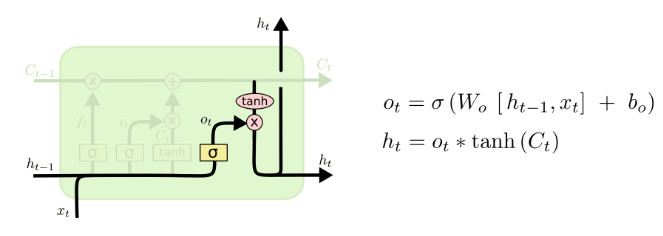

## Import required libraries

In [1]:
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.model_selection import train_test_split

Dataset

In [2]:
text = """About the Program
What is the course fee for Fashion Design (FD 2025)
The course follows a monthly subscription model where you have to make monthly payments of Rs 999/month.
What is the total duration of the course?
The total duration of the course is 6 months. So the total course fee becomes 999*6 = Rs 5994(approx.)
What is the syllabus of the mentorship program?
We will be covering the following modules:
Introduction to Fashion Design
Fabric and Textiles
Fashion Illustration
Pattern Making
Garment Construction
Fashion Marketing
Sustainable Fashion
Fashion Business
You can check the detailed syllabus here - https://fashion.in/courses/Fashion-Design-637339afe4b03535a1bbed390
Will Advanced Sewing Techniques and Digital Fashion be a part of this program?
No, Advanced Sewing Techniques and Digital Fashion both are not a part of this program’s curriculum.
What if I miss a live session? Will I get a recording of the session?
Yes all our sessions are recorded, so even if you miss a session you can go back and watch the recording.
Where can I find the class schedule?
Checkout this google sheet to see month by month time table of the course - https://docs.google.com/spreadsheets/d/16yr36_A6ORAeCg4emgexhqqfhfypKU7RJ6ArOzk/edit?usp=sharing.
What is the time duration of all the live sessions?
Roughly, all the sessions last 3 hours.
What is the language spoken by the instructor during the sessions?
English
How will I be informed about the upcoming class?
You will get a mail from our side before every paid session once you become a paid user.
Can I do this course if I am from a non-fashion background?
Yes, absolutely.
I am late, can I join the program in the middle?
Absolutely, you can join the program anytime.
If I join/pay in the middle, will I be able to see all the past lectures?
Yes, once you make the payment you will be able to see all the past content in your dashboard.
Where do I have to submit the task?
You don’t have to submit the task. We will provide you with the solutions, you have to self evaluate the task yourself.
Will we do case studies in the program?
Yes.
Where can we contact you?
You can mail us at fashion@design.com
Payment/Registration related questions
Where do we have to make our payments? Your YouTube channel or website?
You have to make all your monthly payments on our website. Here is the link for our website - https://fashion.in/
Can we pay the entire amount of Rs 5994 all at once?
Unfortunately no, the program follows a monthly subscription model.
What is the validity of monthly subscription? Suppose if I pay on 15th Jan, then do I have to pay again on 1st Feb or 15th Feb
15th Feb. The validity period is 30 days from the day you make the payment. So essentially you can join anytime you don’t have to wait for a month to end.
What if I don’t like the course after making the payment. What is the refund policy?
You get a 7 days refund period from the day you have made the payment.
I am living outside India and I am not able to make the payment on the website, what should I do?
You have to contact us by sending a mail at fashion@design.com
Post registration queries
Till when can I view the paid videos on the website?
This one is tricky, so read carefully. You can watch the videos till your subscription is valid. Suppose you have purchased subscription on 21st Jan, you will be able to watch all the past paid sessions in the period of 21st Jan to 20th Feb. But after 21st Feb you will have to purchase the subscription again.
But once the course is over and you have paid us Rs 5994(or 6 installments of Rs 999) you will be able to watch the paid sessions till Dec 2025.
Why lifetime validity is not provided?
Because of the low course fee.
Where can I reach out in case of a doubt after the session?
You will have to fill a google form provided in your dashboard and our team will contact you for a 1 on 1 doubt clearance session
If I join the program late, can I still ask past week doubts?
Yes, just select past week doubt in the doubt clearance google form.
I am living outside India and I am not able to make the payment on the website, what should I do?
You have to contact us by sending a mail at fashion@design.com
Certificate and Placement Assistance related queries
What is the criteria to get the certificate?
There are 2 criterias:
You have to pay the entire fee of Rs 5994
You have to attempt all the course assessments.
I am joining late. How can I pay payment of the earlier months?
You will get a link to pay fee of earlier months in your dashboard once you pay for the current month.
I have read that Placement assistance is a part of this program. What comes under Placement assistance?
This is to clarify that Placement assistance does not mean Placement guarantee. So we dont guarantee you any jobs or for that matter even interview calls. So if you are planning to join this course just for placements, I am afraid you will be disappointed. Here is what comes under placement assistance
Portfolio Building sessions
Soft skill sessions
Sessions with industry mentors
Discussion on Job hunting strategies
"""

## Tokenization

In [3]:
# ### Tokenization and Sequence Generation

# Initialize and fit the tokenizer on the text data.
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

In [4]:
len(tokenizer.word_index)

277

In [5]:
tokenizer.word_index

{'the': 1,
 'you': 2,
 'to': 3,
 'i': 4,
 'a': 5,
 'of': 6,
 'is': 7,
 'have': 8,
 'will': 9,
 'fashion': 10,
 'can': 11,
 'what': 12,
 'course': 13,
 'in': 14,
 'program': 15,
 'and': 16,
 'all': 17,
 'sessions': 18,
 'on': 19,
 'be': 20,
 'this': 21,
 'if': 22,
 'am': 23,
 'pay': 24,
 'payment': 25,
 'for': 26,
 'make': 27,
 'we': 28,
 'do': 29,
 'design': 30,
 'subscription': 31,
 'where': 32,
 'rs': 33,
 'so': 34,
 'session': 35,
 'our': 36,
 'paid': 37,
 'join': 38,
 'able': 39,
 'your': 40,
 'website': 41,
 'placement': 42,
 'fee': 43,
 'monthly': 44,
 'month': 45,
 'not': 46,
 'get': 47,
 'yes': 48,
 'once': 49,
 'past': 50,
 'feb': 51,
 'assistance': 52,
 '5994': 53,
 'are': 54,
 'watch': 55,
 'google': 56,
 'by': 57,
 'com': 58,
 'mail': 59,
 'from': 60,
 'contact': 61,
 'us': 62,
 'at': 63,
 'or': 64,
 'doubt': 65,
 'payments': 66,
 '999': 67,
 'total': 68,
 'duration': 69,
 '6': 70,
 'months': 71,
 'here': 72,
 'https': 73,
 'part': 74,
 'see': 75,
 'late': 76,
 'dashboard':

In [6]:
# Create input sequences from the tokenized text

#declare ngrams
input_sequences = []
#split the sentence from '\n'
for sentence in text.split('\n'):
  #get tokens
  tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
  for i in range(1,len(tokenized_sentence)):
    n_gram_sequence = tokenized_sentence[:i+1]
    input_sequences.append(n_gram_sequence)

In [7]:
input_sequences

[[88, 1],
 [88, 1, 15],
 [12, 7],
 [12, 7, 1],
 [12, 7, 1, 13],
 [12, 7, 1, 13, 43],
 [12, 7, 1, 13, 43, 26],
 [12, 7, 1, 13, 43, 26, 10],
 [12, 7, 1, 13, 43, 26, 10, 30],
 [12, 7, 1, 13, 43, 26, 10, 30, 141],
 [12, 7, 1, 13, 43, 26, 10, 30, 141, 89],
 [1, 13],
 [1, 13, 90],
 [1, 13, 90, 5],
 [1, 13, 90, 5, 44],
 [1, 13, 90, 5, 44, 31],
 [1, 13, 90, 5, 44, 31, 91],
 [1, 13, 90, 5, 44, 31, 91, 32],
 [1, 13, 90, 5, 44, 31, 91, 32, 2],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44, 66],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44, 66, 6],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44, 66, 6, 33],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44, 66, 6, 33, 67],
 [1, 13, 90, 5, 44, 31, 91, 32, 2, 8, 3, 27, 44, 66, 6, 33, 67, 45],
 [12, 7],
 [12, 7, 1],
 [12, 7, 1, 68],
 [12, 7, 1, 68, 69],
 [12, 7, 1, 68, 69,

In [8]:
# Check the token sentence
sentence_token = input_sequences[3] # [1, 1561, 5, 129, 34]
sentence = []
for token in sentence_token:
    sentence.append(list((tokenizer.word_index).keys())[list((tokenizer.word_index).values()).index(token)])
print(sentence)

['what', 'is', 'the']


In [9]:
max_len = max([len(x) for x in input_sequences])
print(max_len)

57


In [10]:
# Pad the sequences to a fixed length.
padded_input_sequences = pad_sequences(input_sequences, maxlen = max_len, padding='pre')
padded_input_sequences

array([[  0,   0,   0, ...,   0,  88,   1],
       [  0,   0,   0, ...,  88,   1,  15],
       [  0,   0,   0, ...,   0,  12,   7],
       ...,
       [  0,   0,   0, ..., 274,  19, 275],
       [  0,   0,   0, ...,  19, 275, 276],
       [  0,   0,   0, ..., 275, 276, 277]], dtype=int32)

## Data Splitting and Preparation for Model Training

In [11]:
# Split the padded sequences into features (X) and labels (y)

X = padded_input_sequences[:,:-1]
y = padded_input_sequences[:,-1]

In [12]:
X.shape, y.shape

((853, 56), (853,))

In [13]:
X

array([[  0,   0,   0, ...,   0,   0,  88],
       [  0,   0,   0, ...,   0,  88,   1],
       [  0,   0,   0, ...,   0,   0,  12],
       ...,
       [  0,   0,   0, ...,   0, 274,  19],
       [  0,   0,   0, ..., 274,  19, 275],
       [  0,   0,   0, ...,  19, 275, 276]], dtype=int32)

In [14]:
y

array([  1,  15,   7,   1,  13,  43,  26,  10,  30, 141,  89,  13,  90,
         5,  44,  31,  91,  32,   2,   8,   3,  27,  44,  66,   6,  33,
        67,  45,   7,   1,  68,  69,   6,   1,  13,  68,  69,   6,   1,
        13,   7,  70,  71,  34,   1,  68,  13,  43, 142,  67,  70,  33,
        53, 143,   7,   1,  92,   6,   1, 144,  15,   9,  20, 145,   1,
       146, 147,   3,  10,  30,  16, 150, 151,  93, 154, 155,  10, 157,
        11, 158,   1, 159,  92,  72,  73,  10,  14, 160,  10,  30, 161,
        94,  95,  96,  16,  97,  10,  20,   5,  74,   6,  21,  15,  94,
        95,  96,  16,  97,  10, 162,  54,  46,   5,  74,   6,  21, 163,
       164,  22,   4,  99,   5, 100,  35,   9,   4,  47,   5, 101,   6,
         1,  35,  17,  36,  18,  54, 165,  34, 102,  22,   2,  99,   5,
        35,   2,  11, 166, 167,  16,  55,   1, 101,  11,   4, 168,   1,
       103, 169,  21,  56, 171,   3,  75,  45,  57,  45, 104, 172,   6,
         1,  13,  73, 173,  56,  58, 174, 175, 176, 177, 178, 17

In [15]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
print(X_train.shape, y_train.shape)

(682, 56) (682,)


In [17]:
X_test.shape, y_test.shape

((171, 56), (171,))

In [18]:
# One-hot encode the labels.
y_train = to_categorical(y_train, num_classes=len(tokenizer.word_index) + 1)
y_test = to_categorical(y_test, num_classes=len(tokenizer.word_index) + 1)

In [19]:
y_train.shape, y_test.shape

((682, 278), (171, 278))

In [20]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model Architecture and Compilation

In [21]:
# Define the LSTM model architecture.

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_len - 1))
model.add(LSTM(150))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Compile the model with categorical crossentropy loss and adam optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [24]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Model Training

In [25]:
# Train the LSTM model.
model.fit(X_train,y_train,epochs=100)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0401 - loss: 5.5707
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.0737 - loss: 5.0935
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.0678 - loss: 4.9241
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.0628 - loss: 4.8646
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.0783 - loss: 4.8563
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0929 - loss: 4.7710
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.0890 - loss: 4.7136
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1141 - loss: 4.5343
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1260 - loss: 4.4382
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.1413 - loss: 4.3121
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1389 - loss: 4.1064
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

In [26]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 56, 100)        │        27,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 278)            │        41,978 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,136 (2.52 MB)

 Trainable params: 220,378 (860.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 440,758 (1.68 MB)

None


## Model Evaluation

In [27]:
# Evaluate the model on the training and testing data.
loss_train, accuracy_train = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {accuracy_train}")

loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {accuracy_test}")

Training Accuracy: 0.9604105353355408
Testing Accuracy: 0.23391813039779663


## Text Generation

In [28]:
# Function to generate text based on a starting sequence.
import numpy as np
import time

def generate_text(seed_text, next_words):
    for _ in range(next_words):
        #convert to token
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        #pad sequences
        token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
        #model prediction
        predicted_probabilities = model.predict(token_list)
        predicted_word_index = np.argmax(predicted_probabilities, axis=-1)[0]

        output_word = ""
        # get predicted words
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [29]:
# Generate text starting with ....
print("\nGenerated Text:")
print(generate_text("What is the fee", 10))


Generated Text:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
What is the fee of monthly subscription suppose if i pay on 15th jan


In [30]:
# Generate text starting with ....
print("\nGenerated Text:")
print(generate_text("Hello", 5))


Generated Text:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hello have to contact us by
